# Modelling and Deployment using MLOps 

Now that we have audio input data & corresponding labels in an array format, it is easier to consume and apply Natural language processing techniques. We can convert audio files labels into integers using label Encoding or One Hot Vector Encoding for machines to learn. The labeled dataset will help us in the neural network model output layer for predicting results. These help in training & validation datasets into nD array.
At this stage, we apply other pre-processing techniques like dropping columns, normalization, etc. to conclude our final training data for building models. Moving to the next stage of splitting the dataset into train, test, and validation is what we have been doing for other models. 
We can leverage CNN, RNN, LSTM,CTC etc. deep neural algorithms to build and train the models for speech applications like speech recognition. The model trained with the standard size few seconds audio chunk transformed into an array of n dimensions with the respective labels will result in predicting output labels for test audio input. As output labels will vary beyond binary, we are talking about building a multi-class label classification method.


In [1]:
import pandas as pd
import numpy as np
import os,sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import tensorflow as tf
from clean import Clean
from utils import vocab
from deep_learner import DeepLearn
from modeling import Modeler
from evaluator import CallbackEval

2022-06-08 09:56:47.364581: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-08 09:56:47.364732: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martin-HP-EliteBook-Folio-9470m): /proc/driver/nvidia/version does not exist


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] (size =27)
/home/martin/Documents/swahili_nlp/notebooks


INFO:dvclive:Report path (if generated): /home/martin/Documents/swahili_nlp/notebooks/dvclive/report.html


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
AM_ALPHABET='ሀለሐመሠረሰቀበግዕዝተኀነአከወዐዘየደገጠጰጸፀፈፐቈኈጐኰፙፘፚauiāeəo'
EN_ALPHABET='abcdefghijklmnopqrstuvwxyz'

In [4]:
cleaner = Clean()
char_to_num,num_to_char=vocab(EN_ALPHABET)

2022-06-08 09:56:47,978:logger:Successfully initialized clean class
INFO:logger:Successfully initialized clean class


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] (size =27)


# Deep Learning Model

**objective**: Build a Deep learning model that converts speech to text.

In [5]:
swahili_df = pd.read_csv('../data/swahili.csv')
lang = pd.read_csv("../data/swahili.csv")
lang['type']='swahili'
amharic_df = pd.read_csv("../data/amharic.csv")
amharic_df['type']='amharic'
language_df = lang.append(amharic_df, ignore_index=True)

In [6]:
pre_model = Modeler()

In [7]:
swahili_preprocessed = pre_model.preprocessing_learn(swahili_df,'key','file')

In [8]:
amharic_preprocessed = pre_model.preprocessing_learn(amharic_df,'key','file')

In [9]:
train_df,val_df,test_df = swahili_preprocessed

In [11]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(train_df["file"]), list(train_df["text"]))
)
train_dataset = (
    train_dataset.map(cleaner.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(val_df["file"]), list(val_df["text"]))
)
validation_dataset = (
    validation_dataset.map(cleaner.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


## Deep Learnin Architecture - CNN - RNN - LSTM & CTC

In [38]:
learn = DeepLearn(input_width=1, label_width=1, shift=1,epochs=5,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=['mfcc-0'])
fft_length = 384
model = learn.build_asr_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

# Evaluation

**objective**: Evaluate your model. 

In [ ]:
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(model,validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

2022-06-02 13:17:29.521919: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11888640 exceeds 10% of free system memory.
2022-06-02 13:17:29.555387: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11888640 exceeds 10% of free system memory.
2022-06-02 13:17:29.565880: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11888640 exceeds 10% of free system memory.
2022-06-02 13:17:29.894138: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11888640 exceeds 10% of free system memory.
2022-06-02 13:17:34.276893: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 11888640 exceeds 10% of free system memory.


# Modeling LSTM

In [42]:
input_dim = 384//2 + 1
output_dim = char_to_num.vocabulary_size()

In [43]:
spectrogram = cleaner.convert_spectogram(train_df['file'][0])

In [44]:
len(val_df)

3

In [51]:
t = '../media/audio/SWH-05-20101106_16k-emission_swahili_05h30_-_06h00_tu_20101106_part2.wav'
test_df = pd.DataFrame([t],columns=['file'])
test_df['text'] = 'The quick brown fox jumped over the lazy dog'

In [52]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(test_df["file"]), list(test_df["text"]))
)
train_dataset = (
    train_dataset.map(cleaner.encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

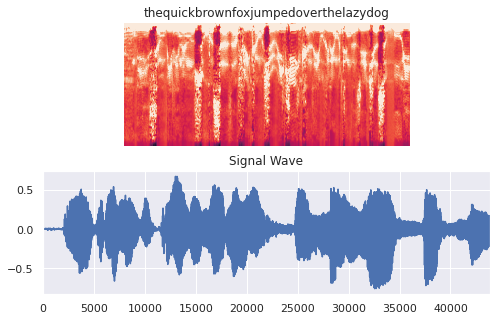

In [53]:
# let us visualize the data
import matplotlib.pyplot as plt
import IPython.display as display
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(list(train_df["file"])[0])
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()


In [13]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 193), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [19]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss


In [20]:
# let us expand the layer to use expanded dimensions
from model_serializer import ModelSerializer
def s_cnn_model(input_dim,output_dim,rnn_layers=5, rnn_units=128):
    input_spectrogram = tf.keras.layers.Input((None, 384//2 + 1), name="input")
    x = tf.keras.layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = tf.keras.layers.BatchNormalization(name="conv_1_bn")(x)
    x = tf.keras.layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = tf.keras.layers.BatchNormalization(name="conv_2_bn")(x)
    x = tf.keras.layers.ReLU(name="conv_2_relu")(x)
    x = tf.keras.layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    for i in range(1, rnn_layers + 1):
        recurrent = tf.keras.layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = tf.keras.layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = tf.keras.layers.Dropout(rate=0.5)(x)
    
    # Dense layer
    x = tf.keras.layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = tf.keras.layers.ReLU(name="dense_1_relu")(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    
    output = tf.keras.layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = tf.keras.Model(input_spectrogram, output, name="SpeechToText")
    # Optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

In [21]:
model_1 = s_cnn_model(input_dim,output_dim)

In [22]:
model_1.summary(line_length=110)

Model: "SpeechToText"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [23]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [54]:
from jiwer import wer
predictions=[]
targets = []
for batch in train_dataset:
    X, y = batch
    batch_predictions = model_1.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = (
            tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        )
        targets.append(label)
    wer_score = wer(targets, predictions)
    print("-" * 100)
    print(f"Word Error Rate: {wer_score:.4f}")
    print("-" * 100)
    for i in range(0, len(predictions)):
        print(f"Target    : {targets[i]}")
        print(f"Prediction: {predictions[i]}")
        print("-" * 100)

1/1 [==============================] - 11s 11s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : thequickbrownfoxjumpedoverthelazydog
Prediction: loioxoxopxoxoxdxo
----------------------------------------------------------------------------------------------------
